In [ ]:
pip install yfinance


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt
import yfinance as yf

In [ ]:
# Obtener datos de IFS mediante yfinance
ticker_symbol = 'BVN'
start_date = '2016-01-01'
end_date = '2024-01-14'
data = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
# Convertir la fecha a formato datetime
data.reset_index(inplace=True)
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
# Seleccionar las columnas de interés
dataset = data[['Date', 'Open', 'High', 'Low', 'Close']]

In [ ]:
# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train_set = dataset[:train_size]
test_set = dataset[train_size:]


In [ ]:

scaler = MinMaxScaler(feature_range=(0, 1))
train_set_scaled = scaler.fit_transform(train_set.iloc[:, 1:])
test_set_scaled = scaler.transform(test_set.iloc[:, 1:])

In [ ]:
# Convertir los datos normalizados a secuencias temporales
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 3])  # 3 corresponde a la columna 'Close'
    return np.array(X), np.array(y)

# Definir la longitud de las secuencias temporales
seq_length = 10
# Crear secuencias temporales para entrenamiento y prueba
X_train, y_train = create_sequences(train_set_scaled, seq_length)
X_test, y_test = create_sequences(test_set_scaled, seq_length)

In [ ]:
# Reshape para que coincida con el formato de entrada de la red LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 4))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 4))

In [ ]:
# Definir la arquitectura del modelo
model = Sequential()
model.add(LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))

# Compilar el modelo
model.compile(loss='mse', optimizer='adam')


In [ ]:
# Entrenar el modelo
model.fit(X_train, y_train, epochs=100, batch_size=32)

Epoch 1/100
51/51 [==============================] - 3s 20ms/step - loss: 0.0362
Epoch 2/100
51/51 [==============================] - 1s 27ms/step - loss: 0.0039
Epoch 3/100
51/51 [==============================] - 1s 28ms/step - loss: 0.0034
Epoch 4/100
51/51 [==============================] - 1s 19ms/step - loss: 0.0032
Epoch 5/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0027
Epoch 6/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 7/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 8/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0026
Epoch 9/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0025
Epoch 10/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0022
Epoch 11/100
51/51 [==============================] - 1s 14ms/step - loss: 0.0023
Epoch 12/100
51/51 [==============================] - 1s 15ms/step - loss: 0.0023
Epoch 13/100
51/51 [=====

In [ ]:
# Predecir los valores de las acciones
predictions = model.predict(X_test)

13/13 [==============================] - 1s 6ms/step


In [ ]:
# Desnormalizar las predicciones
predictions = scaler.inverse_transform(np.concatenate((np.zeros((len(predictions), 3)), predictions), axis=1))[:, 3:]

In [ ]:
# Desnormalizar los valores reales
y_test = scaler.inverse_transform(np.concatenate((np.zeros((len(y_test), 3)), np.reshape(y_test, (len(y_test), 1))), axis=1))[:, 3:]

In [ ]:
# Evaluar el modelo
rmse = np.sqrt(mean_squared_error(y_test, predictions))
print('RMSE:', rmse)

RMSE: 0.26748493447171046


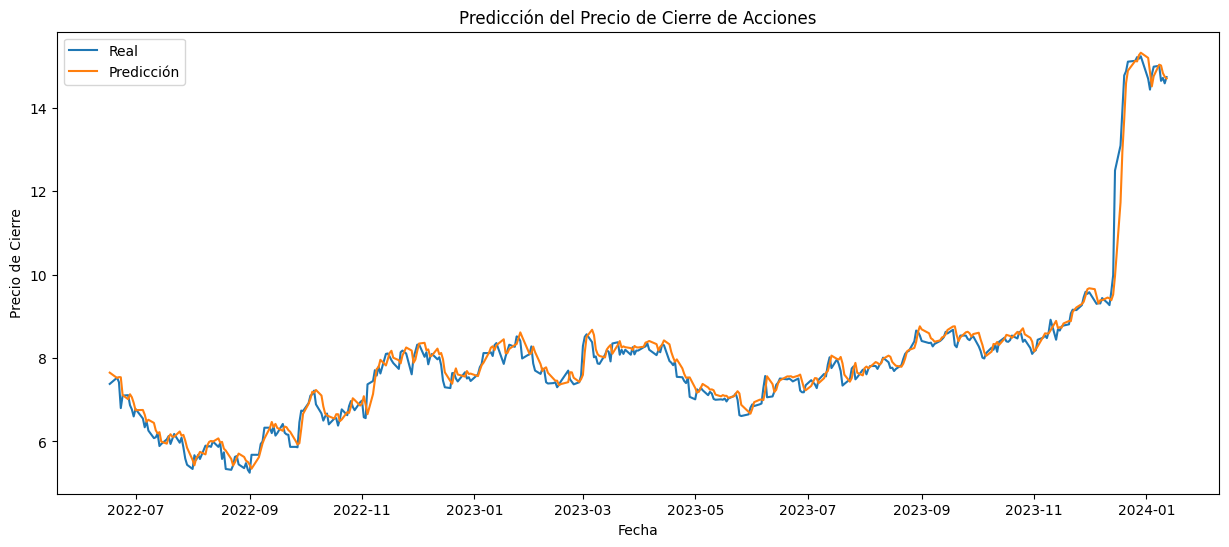

In [ ]:
# Crear una gráfica para visualizar las predicciones
plt.figure(figsize=(15, 6))
plt.plot(test_set['Date'].iloc[seq_length:], y_test, label='Real')
plt.plot(test_set['Date'].iloc[seq_length:], predictions, label='Predicción')
plt.title('Predicción del Precio de Cierre de Acciones')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [ ]:
# Función para generar señales de compra y venta
def generar_senales_compra_venta(y_test, predictions):
    senales_compra = []
    senales_venta = []

    for i in range(1, len(predictions)):
        if predictions[i] > predictions[i-1]:
            senales_compra.append(i)
        elif predictions[i] < predictions[i-1]:
            senales_venta.append(i)

    return senales_compra, senales_venta


In [ ]:
# Generar señales de compra y venta
senales_compra, senales_venta = generar_senales_compra_venta(y_test, predictions)

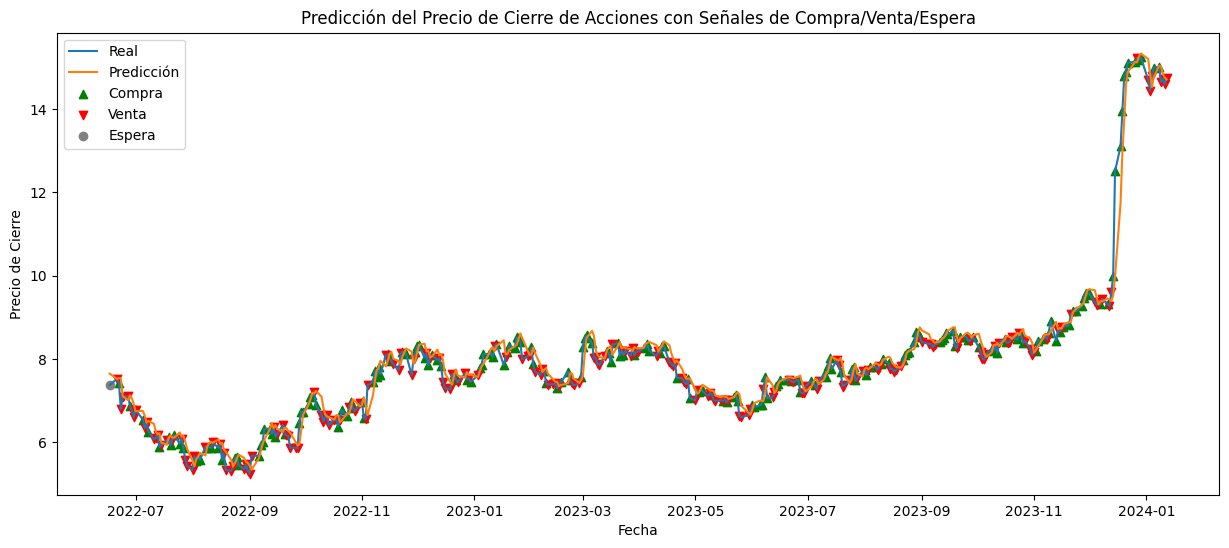

In [ ]:
# Crear una gráfica para visualizar las predicciones con señales de compra (verde), venta (rojo) y espera (gris)
plt.figure(figsize=(15, 6))
plt.plot(test_set['Date'].iloc[seq_length:], y_test, label='Real')
plt.plot(test_set['Date'].iloc[seq_length:], predictions, label='Predicción')
# Agregar puntos verdes para señales de compra
plt.scatter(test_set['Date'].iloc[seq_length + np.array(senales_compra)], y_test[senales_compra], marker='^', color='g', label='Compra')
# Agregar puntos rojos para señales de venta
plt.scatter(test_set['Date'].iloc[seq_length + np.array(senales_venta)], y_test[senales_venta], marker='v', color='r', label='Venta')
# Identificar períodos sin señales (puntos grises)
periodos_espera = set(range(len(predictions))) - set(senales_compra) - set(senales_venta)
plt.scatter(test_set['Date'].iloc[seq_length + np.array(list(periodos_espera))], y_test[list(periodos_espera)], marker='o', color='gray', label='Espera')

plt.title('Predicción del Precio de Cierre de Acciones con Señales de Compra/Venta/Espera')
plt.xlabel('Fecha')
plt.ylabel('Precio de Cierre')
plt.legend()
plt.show()

In [ ]:
# Calcular el valor total de la inversión para cada transacción
def calcular_valor_inversion(cantidad_inversion, senales_compra, senales_venta, y_test):
    valor_inversion = 0
    cantidad_acciones = 0
    inversion_inicial = None

    for i in range(len(y_test)):
        if i in senales_compra:
            if inversion_inicial is None:
                inversion_inicial = y_test[i]
                cantidad_acciones = cantidad_inversion / inversion_inicial
                valor_inversion = cantidad_acciones * y_test[i]
        elif i in senales_venta:
            if inversion_inicial is not None:
                valor_inversion += cantidad_acciones * y_test[i]
                cantidad_acciones = 0
                inversion_inicial = None

    if inversion_inicial is not None:
        # Vender las acciones restantes al final del periodo
        valor_inversion += cantidad_acciones * y_test[-1]

    return valor_inversion

In [ ]:
# Definir la cantidad de inversión
cantidad_inversion = 10000  # Puedes ajustar esto según tu preferencia


In [ ]:
# Calcular el valor total de la inversión
valor_inversion_final = calcular_valor_inversion(cantidad_inversion, senales_compra, senales_venta, y_test)


In [ ]:
# Asegurarse de que valor_inversion_final sea un número (extraer el escalar si es necesario)
valor_inversion_final = valor_inversion_final[0] if isinstance(valor_inversion_final, np.ndarray) else valor_inversion_final


In [ ]:
# Calcular el rendimiento total de la inversión
rendimiento_total = ((valor_inversion_final - cantidad_inversion) / cantidad_inversion) * 100


In [ ]:
print('Valor de la inversión final:', round(valor_inversion_final, 2))
print('Rendimiento total de la inversión:', round(rendimiento_total, 2), '%')

Valor de la inversión final: 19773.18
Rendimiento total de la inversión: 97.73 %


In [ ]:
# Obtener la última predicción
ultima_prediccion = predictions[-1][0]

# Determinar si comprar o vender según la última predicción
if ultima_prediccion > y_test[-1]:
    decision = 'Comprar'
elif ultima_prediccion < y_test[-1]:
    decision = 'Vender'
else:
    decision = 'Esperar'

# Imprimir la última predicción y la decisión
print('Última Predicción:', ultima_prediccion)
print('Decisión:', decision)


Última Predicción: 14.705791536394598
Decisión: Vender


In [ ]:
# Obtener la fecha del último día en el conjunto de prueba
ultima_fecha_test = test_set['Date'].iloc[-1]

# Obtener los datos del último día en el conjunto de prueba y normalizarlos
ultimo_dia_test = test_set[test_set['Date'] == ultima_fecha_test].iloc[:, 1:].values
ultimo_dia_test_scaled = scaler.transform(ultimo_dia_test)

# Crear una secuencia temporal para el último día en el conjunto de prueba
X_next_day = np.array([test_set_scaled[-seq_length:]])

# Reshape para que coincida con el formato de entrada de la red LSTM
X_next_day = np.reshape(X_next_day, (X_next_day.shape[0], X_next_day.shape[1], 4))

# Predecir el siguiente día
next_day_prediction = model.predict(X_next_day)

# Desnormalizar la predicción del siguiente día
next_day_prediction = scaler.inverse_transform(np.concatenate((np.zeros((1, 3)), next_day_prediction), axis=1))[:, 3:]

# Imprimir la predicción del siguiente día
print('Predicción para el siguiente día después de', ultima_fecha_test, ':', next_day_prediction[0][0])

# Determinar si comprar, vender o esperar en función de la predicción
if next_day_prediction[0][0] > ultimo_dia_test[0][3]:
    decision_next_day = 'Comprar'
elif next_day_prediction[0][0] < ultimo_dia_test[0][3]:
    decision_next_day = 'Vender'
else:
    decision_next_day = 'Esperar'

# Imprimir la decisión para el siguiente día
print('Decisión para el siguiente día:', decision_next_day)


1/1 [==============================] - 0s 39ms/step
Predicción para el siguiente día después de 2024-01-12 00:00:00 : 14.945194821419475
Decisión para el siguiente día: Comprar


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
